# Importing libraries

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf 
from pyspark.context import SparkContext
from pyspark.sql import functions as F
from pyspark.sql import types as T 
import pandas as pd

# Preconfiguring

In [2]:
credentials_location = '/home/alex/.google/credentials/sanguine-form-376720-9f11d64bdbbd.json'

conf = SparkConf() \
        .setMaster('local[*]') \
        .setAppName('test') \
        .set('spark.jars', '/home/alex/lib/gcs-connector-hadoop3-latest.jar') \
        .set('spark.hadoop.google.cloud.auth.service.account.enable', 'true') \
        .set('spark.hadoop.google.cloud.auth.service.account.json.keyfile', credentials_location)

In [3]:
sc = SparkContext(conf=conf)

23/03/04 08:34:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/04 08:34:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
hadoop_conf = sc._jsc.hadoopConfiguration()

hadoop_conf.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
hadoop_conf.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
hadoop_conf.set("fs.gs.auth.service.account.json.keyfile", credentials_location)
hadoop_conf.set("fs.gs.auth.service.account.enable", "true")

In [5]:
spark = SparkSession.builder \
    .config(conf=sc.getConf()) \
    .getOrCreate()

In [6]:
input_path = 'gs://iskanderrus_dez_data_lake_sanguine-form-376720/data/fhv/fhvhv_tripdata_2021-06.csv.gz'
output_path = 'gs://iskanderrus_dez_data_lake_sanguine-form-376720/data/fhv/parquet/2021/06/'

# Question 1

In [7]:
spark.version

'3.3.2'

In [8]:
spark

# Question 2

In [9]:
df_fhv = spark.read \
            .option('header', 'true') \
            .csv(input_path)

In [10]:
df_fhv.show(5)

+--------------------+-------------------+-------------------+------------+------------+-------+----------------------+
|dispatching_base_num|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|SR_Flag|Affiliated_base_number|
+--------------------+-------------------+-------------------+------------+------------+-------+----------------------+
|              B02764|2021-06-01 00:02:41|2021-06-01 00:07:46|         174|          18|      N|                B02764|
|              B02764|2021-06-01 00:16:16|2021-06-01 00:21:14|          32|         254|      N|                B02764|
|              B02764|2021-06-01 00:27:01|2021-06-01 00:42:11|         240|         127|      N|                B02764|
|              B02764|2021-06-01 00:46:08|2021-06-01 00:53:45|         127|         235|      N|                B02764|
|              B02510|2021-06-01 00:45:42|2021-06-01 01:03:33|         144|         146|      N|                  null|
+--------------------+------------------

In [11]:
df_fhv.printSchema()

root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- SR_Flag: string (nullable = true)
 |-- Affiliated_base_number: string (nullable = true)



In [12]:
df_fhv = df_fhv \
            .withColumn('pickup_datetime', F.to_timestamp(df_fhv.pickup_datetime)) \
            .withColumn('dropoff_datetime', F.to_timestamp(df_fhv.dropoff_datetime)) \
            .withColumn('PULocationID', df_fhv.PULocationID.cast(T.IntegerType())) \
            .withColumn('DOLocationID', df_fhv.DOLocationID.cast(T.IntegerType()))

In [13]:
df_fhv.printSchema()

root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: string (nullable = true)
 |-- Affiliated_base_number: string (nullable = true)



In [14]:
df_fhv \
    .repartition(12) \
    .write.parquet(output_path, mode='overwrite')

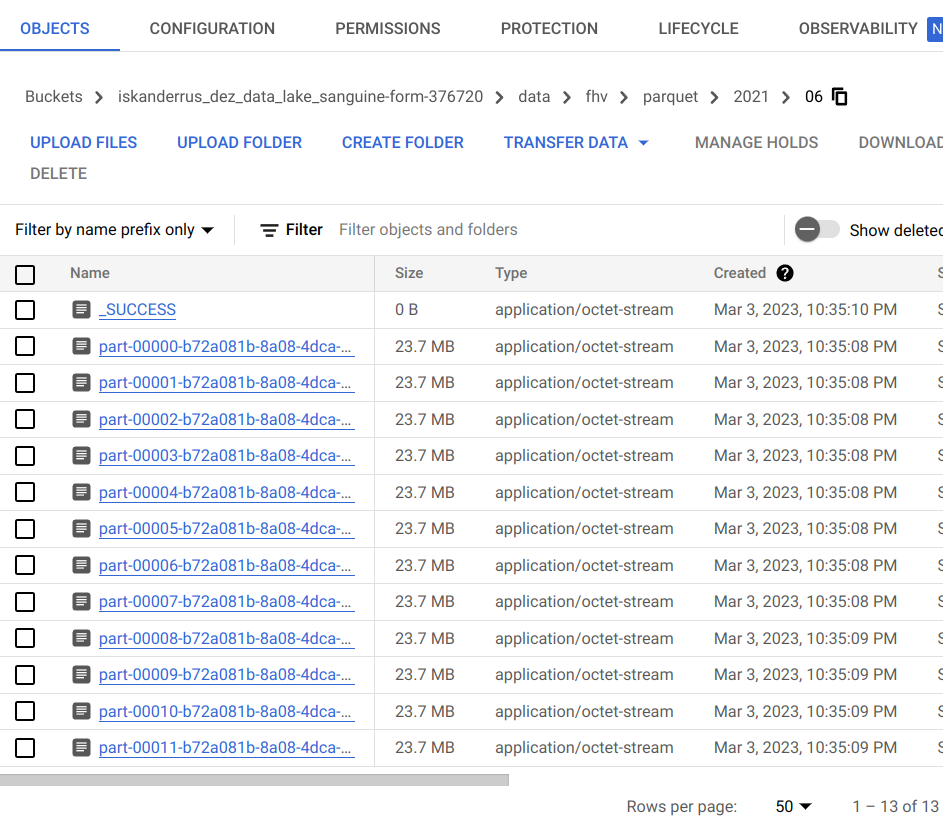

# Question 3

In [15]:
df_fhv.createOrReplaceTempView('df_fhv_data')

In [16]:
trips_june_15th = spark.sql("""
SELECT 
    DATE(pickup_datetime) as date,
    COUNT(1) AS number_of_records
FROM 
    df_fhv_data
WHERE 
    EXTRACT(DAY FROM pickup_datetime)=15
GROUP BY date;
""")

In [17]:
trips_june_15th.show()

+----------+-----------------+
|      date|number_of_records|
+----------+-----------------+
|2021-06-15|           452470|
+----------+-----------------+



# Question 4

In [18]:
longest_trip = spark.sql("""
SELECT 
    (unix_timestamp(dropoff_datetime) - unix_timestamp(pickup_datetime))/3600 as trip_duration
FROM 
    df_fhv_data
ORDER BY trip_duration DESC
LIMIT 1
""")

In [19]:
longest_trip.show()

+----------------+
|   trip_duration|
+----------------+
|66.8788888888889|
+----------------+



# Question 5

Normally 4040, but: 

In [20]:
sc.uiWebUrl.split(':')[-1]

'4041'

# Question 6

In [21]:
df_zones = spark.read \
            .option('header', 'true') \
            .csv('gs://iskanderrus_dez_data_lake_sanguine-form-376720/data/taxi_zone_lookup.csv')

In [22]:
df_zones.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



In [23]:
df_zones.printSchema()

root
 |-- LocationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [24]:
df_zones = df_zones \
            .withColumn('LocationID', df_zones.LocationID.cast(T.IntegerType()))

In [25]:
df_zones.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [26]:
df_joint_zones = df_fhv.join(df_zones, df_fhv.PULocationID == df_zones.LocationID)

In [27]:
df_joint_zones.printSchema()

root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- SR_Flag: string (nullable = true)
 |-- Affiliated_base_number: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [28]:
df_joint_zones = df_joint_zones.select('LocationID', 'Zone')

In [29]:
df_joint_zones.createOrReplaceTempView('df_joint_zones_data')

In [30]:
df_joint_zones.show()

+----------+--------------------+
|LocationID|                Zone|
+----------+--------------------+
|       174|             Norwood|
|        32|           Bronxdale|
|       240|  Van Cortlandt Park|
|       127|              Inwood|
|       144| Little Italy/NoLiTa|
|        49|        Clinton Hill|
|        49|        Clinton Hill|
|       225|  Stuyvesant Heights|
|       209|             Seaport|
|        80|   East Williamsburg|
|       217|  South Williamsburg|
|        17|             Bedford|
|       210|      Sheepshead Bay|
|       226|           Sunnyside|
|       191|      Queens Village|
|        16|             Bayside|
|       182|         Parkchester|
|       188|Prospect-Lefferts...|
|        39|            Canarsie|
|        72|East Flatbush/Rem...|
+----------+--------------------+
only showing top 20 rows



In [32]:
most_frequent_zone = spark.sql("""
SELECT 
    Zone,
    COUNT(LocationID) AS counter
FROM 
    df_joint_zones_data
GROUP BY Zone
ORDER BY counter DESC;
""")

In [33]:
most_frequent_zone.show()

+--------------------+-------+
|                Zone|counter|
+--------------------+-------+
| Crown Heights North| 231279|
|        East Village| 221244|
|         JFK Airport| 188867|
|      Bushwick South| 187929|
|       East New York| 186780|
|TriBeCa/Civic Center| 164344|
|   LaGuardia Airport| 161596|
|            Union Sq| 158937|
|        West Village| 154698|
|             Astoria| 152493|
|     Lower East Side| 151020|
|        East Chelsea| 147673|
|Central Harlem North| 146402|
|Williamsburg (Nor...| 143683|
|          Park Slope| 143594|
|  Stuyvesant Heights| 141427|
|        Clinton East| 139611|
|West Chelsea/Huds...| 139431|
|             Bedford| 138428|
|         Murray Hill| 137879|
+--------------------+-------+
only showing top 20 rows

